# Reserve capacity allocation

The model setup for the reserve capacity examples presented below are available in the following formats.

- pyshop
    - [reserve_cap.py](#reserve_cap.py)
- YAML
    - [model.yaml](#model.yaml)
    - [reserve_obligation.yaml](#reserve_obligation.yaml)
    - [smooth_reserve.yaml](#smooth_reserve.yaml)
- ASCII
    - [model.ascii](#model.ascii)
    - [reserve_obligation.ascii](#reserve_obligation.ascii)
    - [smooth_reserve.ascii](#smooth_reserve.ascii)

## Optimal distribution of reserve capacity
A simple system with 6 generators located on two separate plants will be used to illustrate the basic features of the **reserve_group** object and the reserve functionality in SHOP. First, we create and run the basic model without any reserve requirements.

In [1]:
#Necessary imports used in all examples
import pandas as pd
import cufflinks as cf
import plotly.offline as py
import plotly.graph_objs as go
cf.go_offline()
py.offline.init_notebook_mode(connected=True)
from pyshop import ShopSession

#Functions used in this example for building and solving a simple model with cuts
from reserve_cap import build_model, run_model

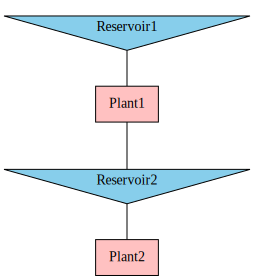

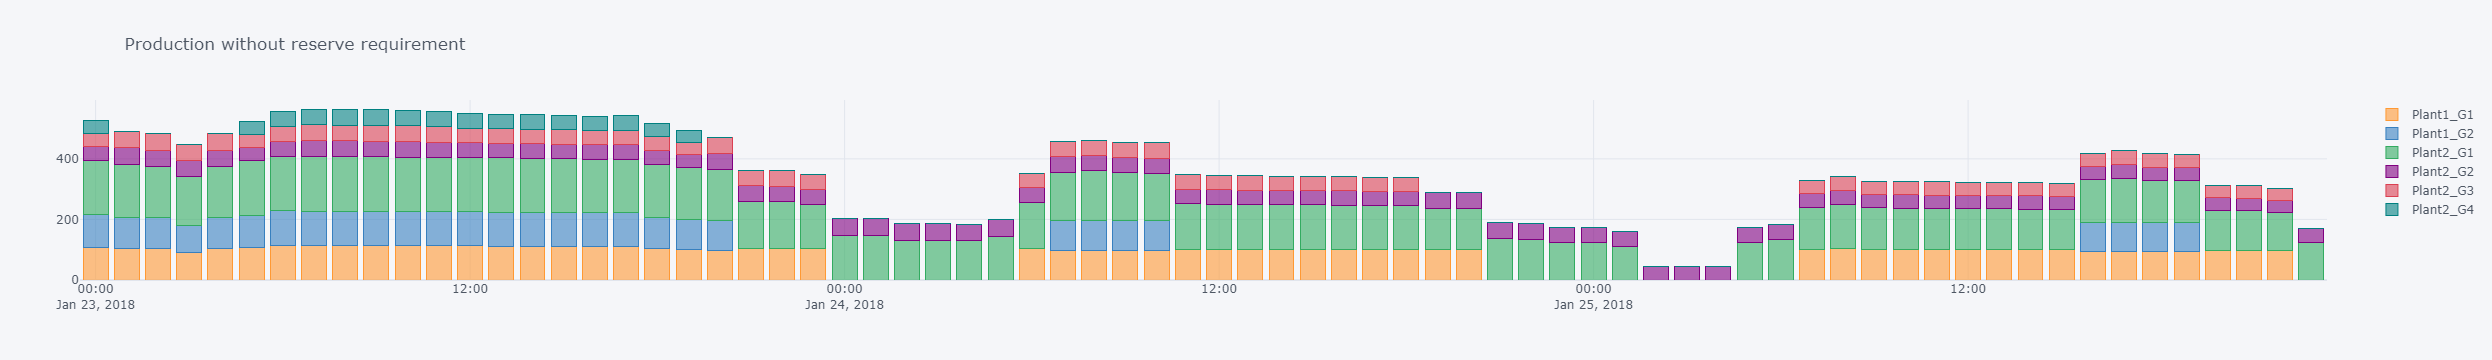

In [2]:
#Create a standard ShopSession
shop=ShopSession()
#Build a simple model with two reservoirs, two plants, and 6 generators.
build_model(shop)
#Display topology to the screen
display(shop.model.build_connection_tree())

#Run an optimization without any reserve obligations
run_model(shop)
#Display the optimal production level
pd.DataFrame([gen.production.get().rename(gen.get_name()) for gen in shop.model.generator]).transpose().iplot(title="Production without reserve requirement", kind='bar', barmode = 'stack')

Now we create an identical SHOP model but add two **reserve_group** objects with some specified FCR-N and FRR reserve obligations. All generators are part of the FCR-N group and can help cover the given **fcr_n_up_obligation** and **fcr_n_down_obligation**. Only the generators in Plant2 are part of the FRR group and have to cover the **frr_up_obligation** without help from the other generators in Plant1. 

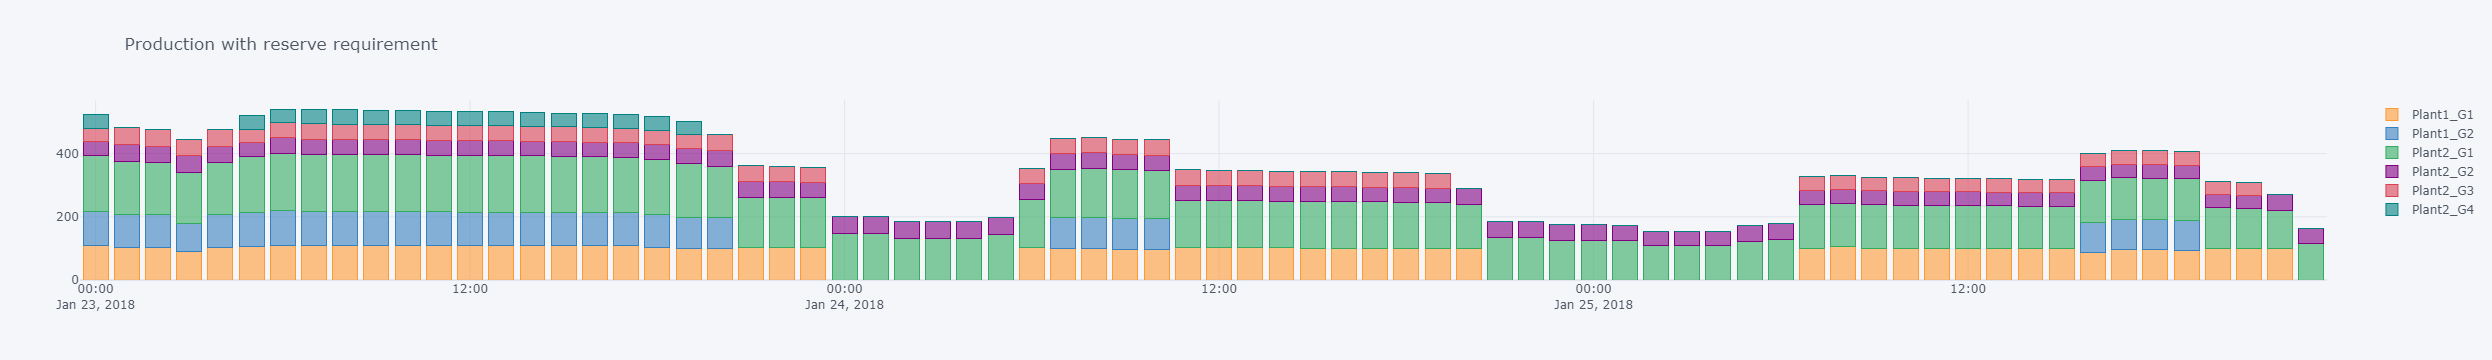

In [3]:
#Create a new shop session
shop=ShopSession()
build_model(shop)

#Add two reserve_group objects to the original model
fcr_n = shop.model.reserve_group.add_object("fcr_n_group")
fcr_n.fcr_n_up_obligation.set(10)
fcr_n.fcr_n_down_obligation.set(10)

frr = shop.model.reserve_group.add_object("frr_group")
frr.frr_up_obligation.set(15)

#Connect all generators to the fcr_n group
for gen in shop.model.generator:
    gen.connect_to(fcr_n)

#Connect only the generators in Plant2 to the frr group
plant2 = shop.model.plant.Plant2    
for gen in plant2.generators:
    gen.connect_to(frr)    
    
#Optimize model
run_model(shop) 

#Plot the resulting optimized production schedules
pd.DataFrame([gen.production.get().rename(gen.get_name()) for gen in shop.model.generator]).transpose().iplot(title="Production with reserve requirement", kind='bar', barmode = 'stack')

The optimal production set points have shifted for some of the generators due to the new reserve capacity obligations. The plots below show how the reserve capacity has been distributed among the generators.

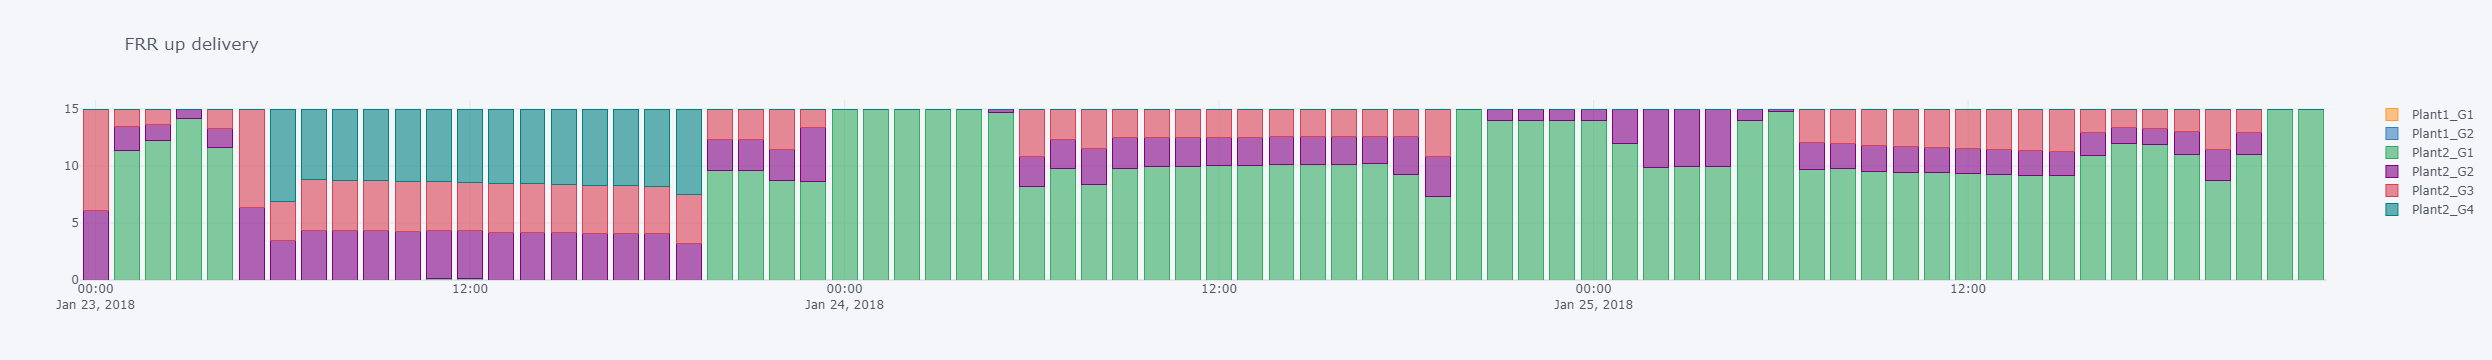

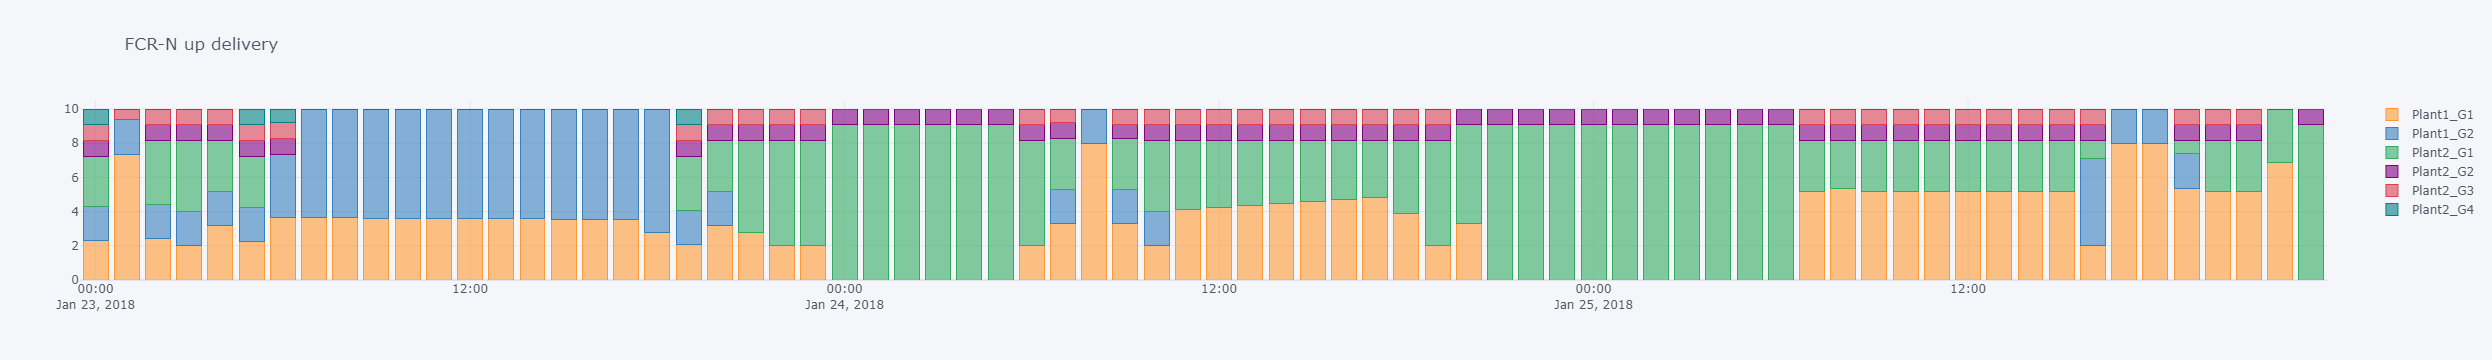

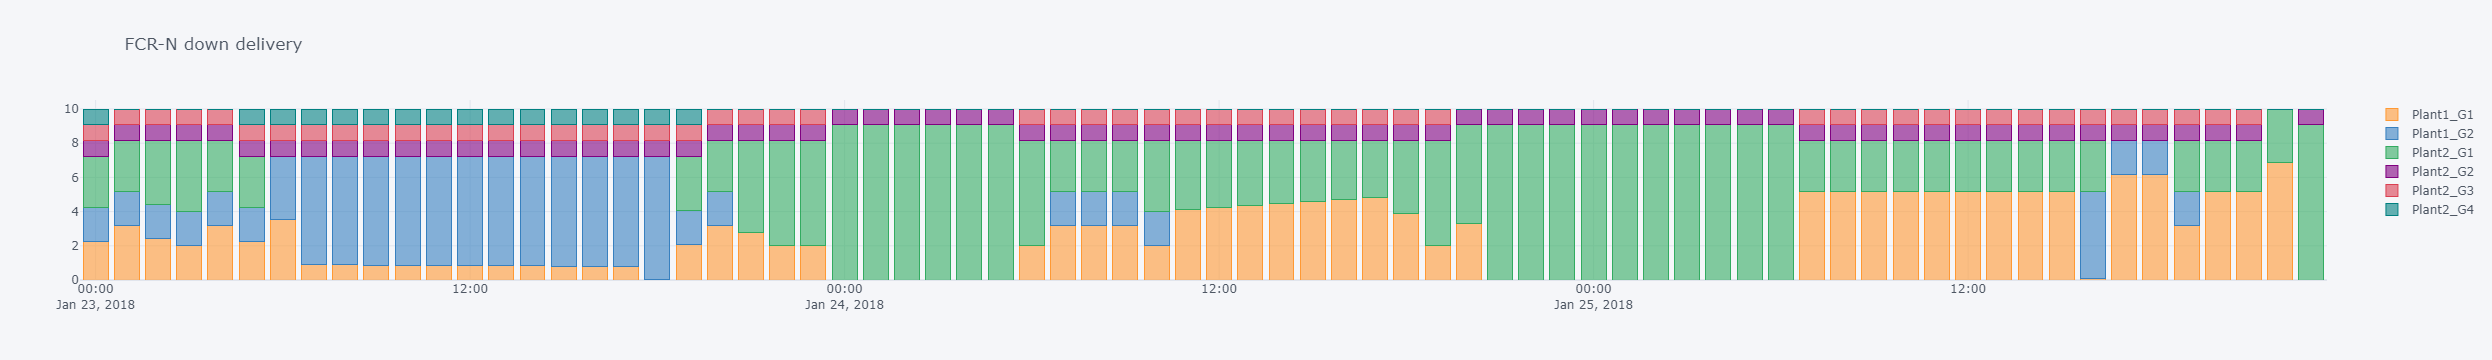

In [4]:
pd.DataFrame([gen.frr_up_delivery.get().rename(gen.get_name()) for gen in shop.model.generator]).transpose().iplot(title="FRR up delivery", kind='bar', barmode = 'stack')
pd.DataFrame([gen.fcr_n_up_delivery.get().rename(gen.get_name()) for gen in shop.model.generator]).transpose().iplot(title="FCR-N up delivery", kind='bar', barmode = 'stack')
pd.DataFrame([gen.fcr_n_down_delivery.get().rename(gen.get_name()) for gen in shop.model.generator]).transpose().iplot(title="FCR-N down delivery", kind='bar', barmode = 'stack')

Note that the FCR-N reserve capacity is not always symmetric since no **fcr_n_equality_flag** on the global_settings object (or equivalent command) has been specified. 

The following plots give a more detailed look at the individual generator production and reserve capacity results:

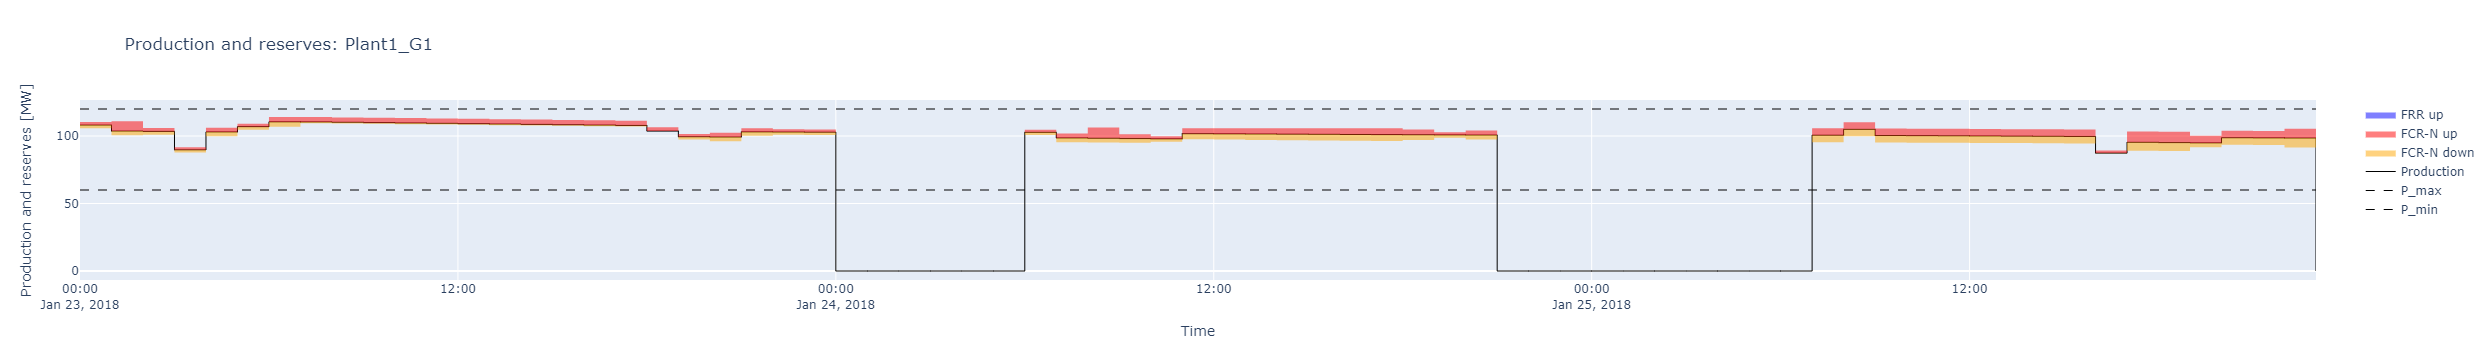

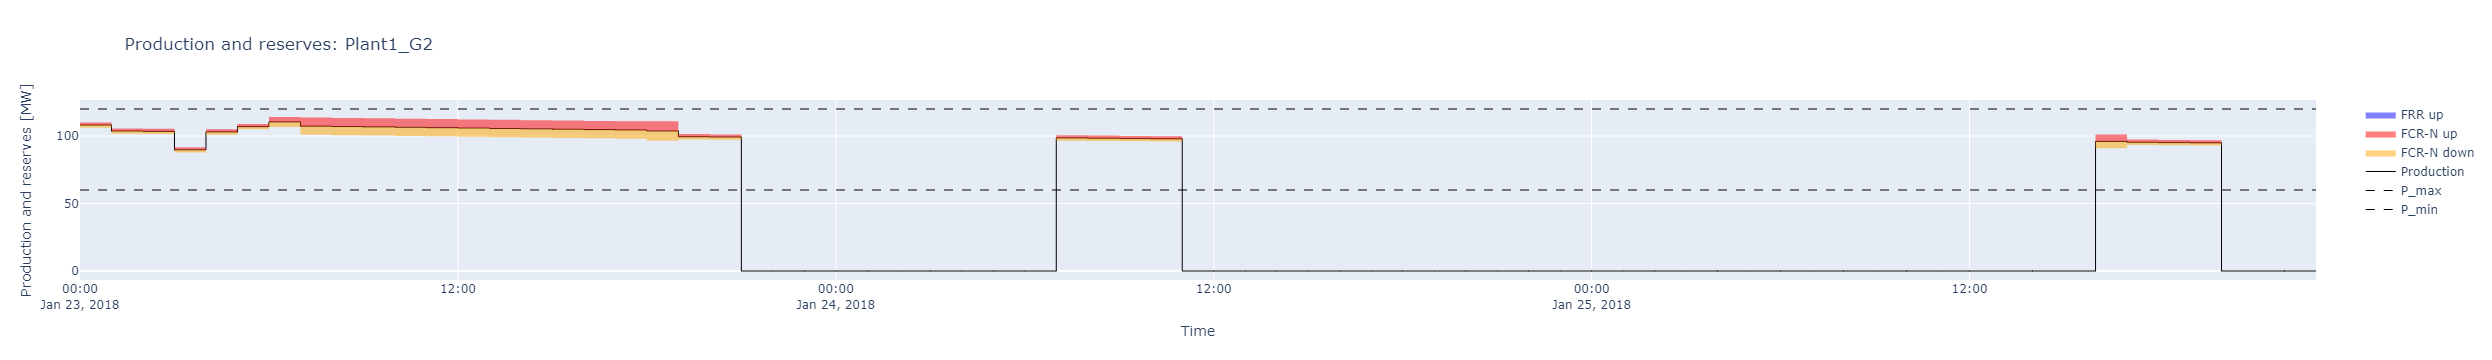

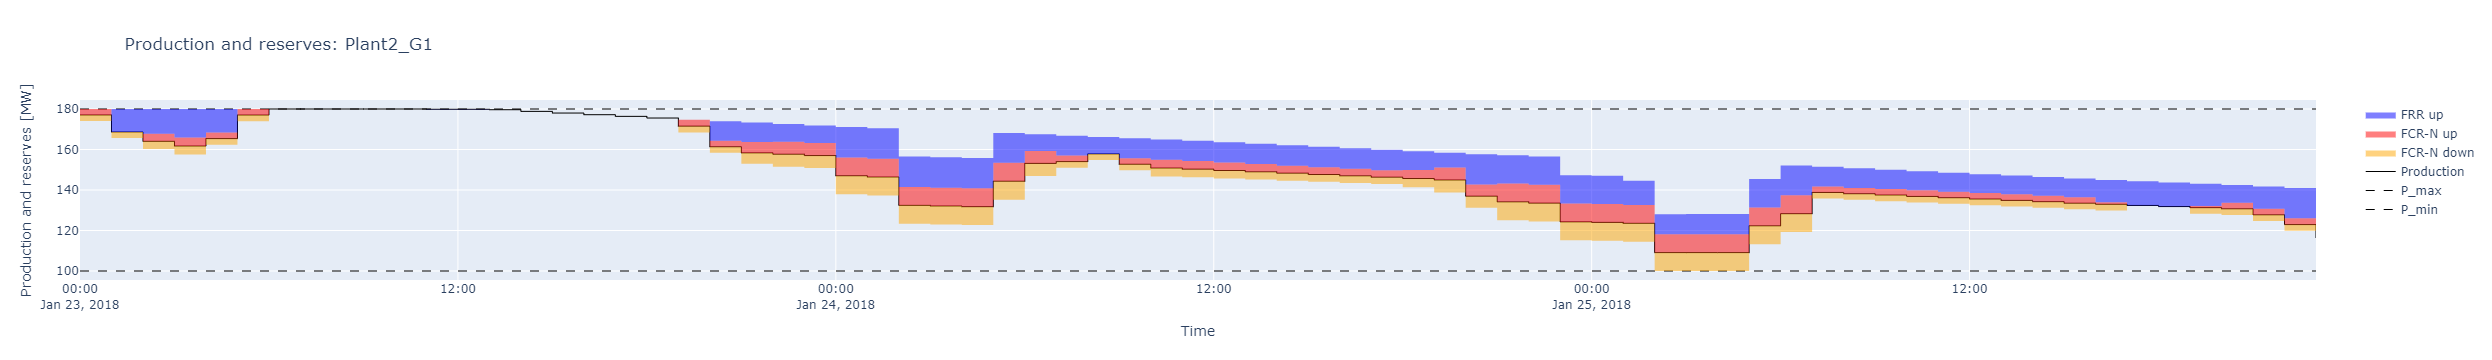

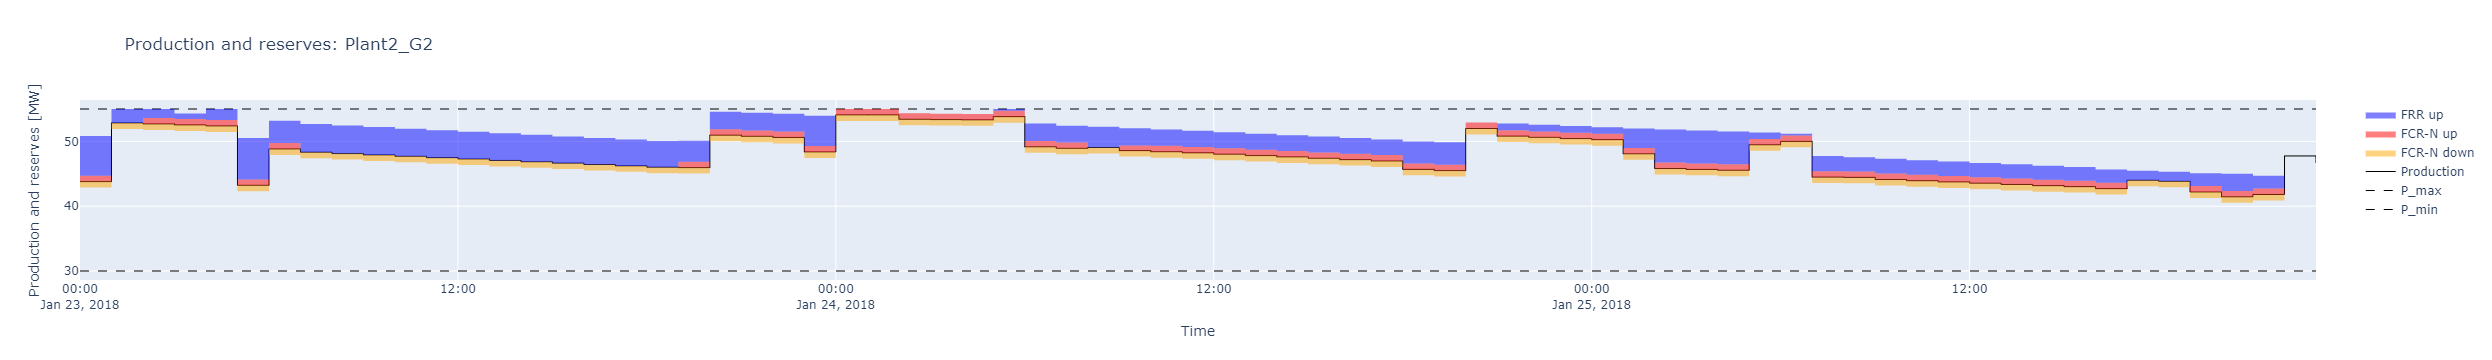

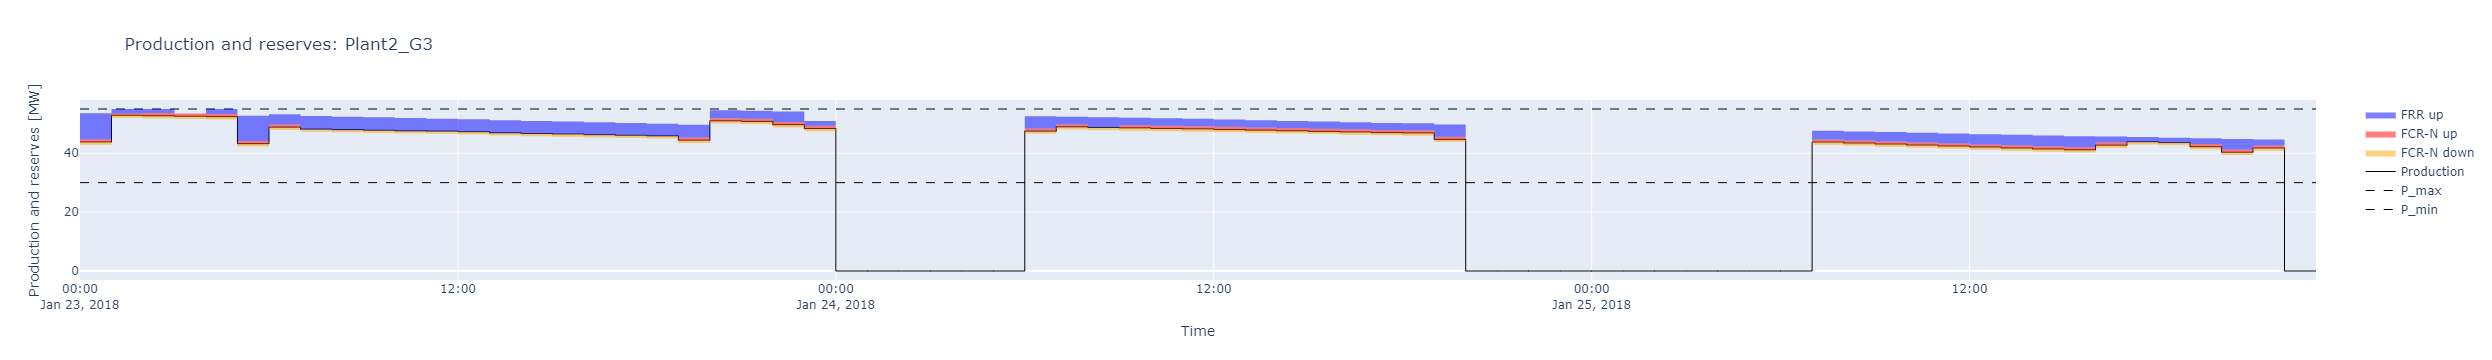

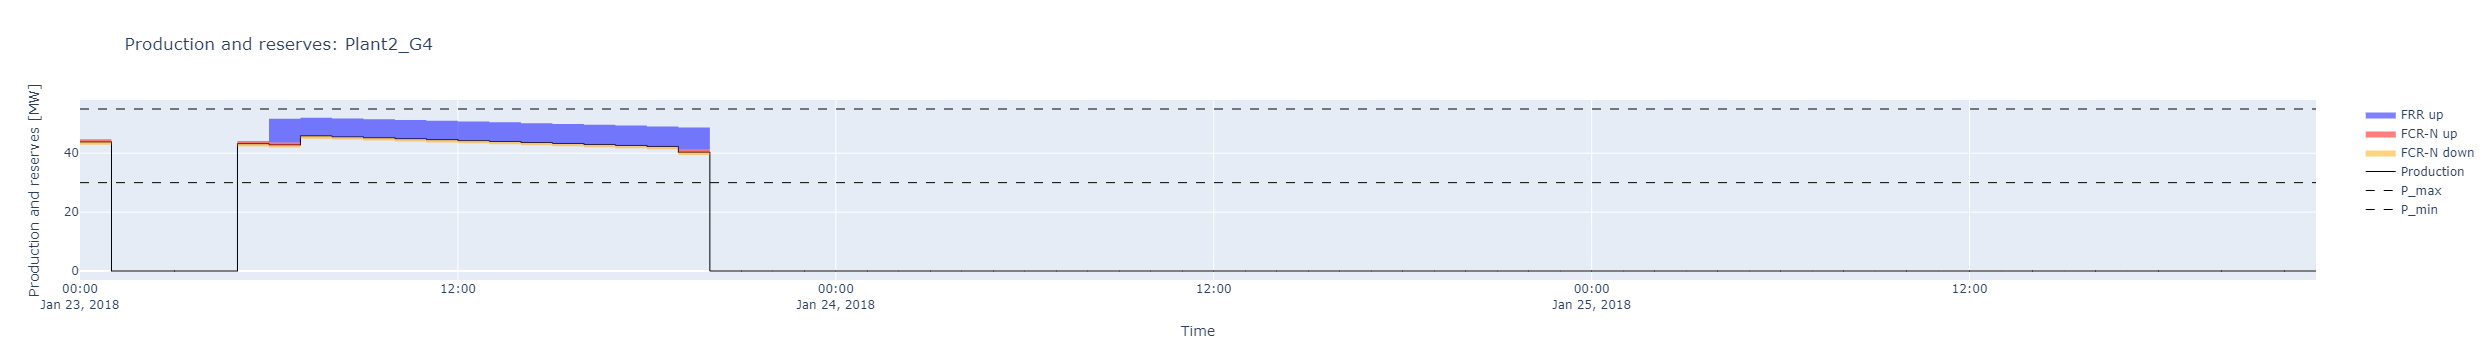

In [5]:
for gen in shop.model.generator:
    name = gen.get_name()
    p_min = gen.p_min.get()
    p_max = gen.p_max.get()
    prod = gen.production.get()
    frr_up = gen.frr_up_delivery.get()
    fcr_n_up = gen.fcr_n_up_delivery.get()
    fcr_n_down = gen.fcr_n_down_delivery.get()

    t = prod.index
    
    fig = go.Figure(layout={'title':"Production and reserves: "+name,'xaxis_title':"Time",'yaxis_title':"Production and reserves [MW]"})
    
    fig.add_trace(go.Scatter(name="P_min",x=t,y=[p_min]*len(t),line={'color': "black", 'width': 1,'dash':"dash"}))    
    fig.add_trace(go.Scatter(name="P_max",x=t,y=[p_max]*len(t),line={'color': "black", 'width': 1,'dash':"dash"}))    
    fig.add_trace(go.Scatter(name="Production",x=t,y=prod.values,line={'color': "black", 'width': 1},line_shape='hv'))    

    fig.add_trace(go.Scatter(showlegend=False,x=t,y=prod.values-fcr_n_down,line={'color': "black", 'width': 0},line_shape='hv'))    
    fig.add_trace(go.Scatter(name="FCR-N down",x=t, y=prod,fill='tonexty',line={'color': "orange", 'width': 0},line_shape='hv'))
    fig.add_trace(go.Scatter(name="FCR-N up",x=t,y=prod+fcr_n_up, fill='tonexty',line={'color': "red", 'width': 0},line_shape='hv'))    
    fig.add_trace(go.Scatter(name="FRR up",x=t,y=prod+frr_up+fcr_n_up, fill='tonexty',line={'color': "blue", 'width': 0},line_shape='hv'))    
    
    fig.show()


It is possible that the sum of the production and the upward reserve capacity is slightly higher than the maximum production limit. This is usually due to the deviation between optimized and post-calculated production in SHOP, reported as **prod_unbalance** on the plant object. Non-linearities due to head loss effects and the turbine and generator efficiency curves are linearized and iteratively refined in SHOP. The optimized production variables are therefore approximations of the non-linear production function. A small gap is likely to appear when the optimized value is compared to a true non-linear post-calculation of the production based on the optimized discharge. The production unbalance means that the reserve capacity constraints are not broken in the optimization problem even though they appear to be broken when using the post-calculated production reported from SHOP. These are some of the limitations of a linear optimization model.

The amount of reserve capacity allocated on each unit is not very stable over the optimization horizon in the previous optimization run. A way to rectify this is to add a **gen_reserve_ramping_cost** on the global_settings object, penalizing any change in allocation of reserve capacity between two time steps. The example balow adds a reserve ramping cost of 5 €/MW. In addition, a minimum limit of 1 MW is set for delivering the three different reserve capacity products. The potential downside of adding a reserve capacity ramping cost and minimum limits is the increased calculation time.

In [ ]:
#Create a new shop session
shop=ShopSession()
build_model(shop)

#Add two reserve_group objects to the original model
fcr_n = shop.model.reserve_group.add_object("fcr_n_group")
fcr_n.fcr_n_up_obligation.set(10)
fcr_n.fcr_n_down_obligation.set(10)

frr = shop.model.reserve_group.add_object("frr_group")
frr.frr_up_obligation.set(15)

#Connect all generators to the fcr_n group
for gen in shop.model.generator:
    gen.connect_to(fcr_n)
    
    gen.fcr_n_up_min.set(1)
    gen.fcr_n_down_min.set(1)
    
#Connect only the generators in Plant2 to the frr group
plant2 = shop.model.plant.Plant2    
for gen in plant2.generators:
    gen.connect_to(frr)    
    
    gen.frr_up_min.set(1)
    
#Add a reserve ramping cost    
settings = shop.model.global_settings.global_settings
settings.gen_reserve_ramping_cost.set(5)
    
#Optimize model
run_model(shop) 

#Plot the reserve capacity distribution
pd.DataFrame([gen.frr_up_delivery.get().rename(gen.get_name()) for gen in shop.model.generator]).transpose().iplot(title="FRR up delivery", kind='bar', barmode = 'stack')
pd.DataFrame([gen.fcr_n_up_delivery.get().rename(gen.get_name()) for gen in shop.model.generator]).transpose().iplot(title="FCR-N up delivery", kind='bar', barmode = 'stack')
pd.DataFrame([gen.fcr_n_down_delivery.get().rename(gen.get_name()) for gen in shop.model.generator]).transpose().iplot(title="FCR-N down delivery", kind='bar', barmode = 'stack')


Generator 1 on Plant2 delivers most of the reserve capacity when minimum limits and reserve ramping costs are added to the optimization problem. The unit commitment and production schedules of the generators have been altered to accomodoate the smoother reserve capacity commitment:

In [ ]:
for gen in shop.model.generator:
    name = gen.get_name()
    p_min = gen.p_min.get()
    p_max = gen.p_max.get()
    prod = gen.production.get()
    frr_up = gen.frr_up_delivery.get()
    fcr_n_up = gen.fcr_n_up_delivery.get()
    fcr_n_down = gen.fcr_n_down_delivery.get()

    t = prod.index
    
    fig = go.Figure(layout={'title':"Production and reserves: "+name,'xaxis_title':"Time",'yaxis_title':"Production and reserves [MW]"})
    
    fig.add_trace(go.Scatter(name="P_min",x=t,y=[p_min]*len(t),line={'color': "black", 'width': 1,'dash':"dash"}))    
    fig.add_trace(go.Scatter(name="P_max",x=t,y=[p_max]*len(t),line={'color': "black", 'width': 1,'dash':"dash"}))    
    fig.add_trace(go.Scatter(name="Production",x=t,y=prod.values,line={'color': "black", 'width': 1},line_shape='hv'))    

    fig.add_trace(go.Scatter(showlegend=False,x=t,y=prod.values-fcr_n_down,line={'color': "black", 'width': 0},line_shape='hv'))    
    fig.add_trace(go.Scatter(name="FCR-N down",x=t, y=prod,fill='tonexty',line={'color': "orange", 'width': 0},line_shape='hv'))
    fig.add_trace(go.Scatter(name="FCR-N up",x=t,y=prod+fcr_n_up, fill='tonexty',line={'color': "red", 'width': 0},line_shape='hv'))    
    fig.add_trace(go.Scatter(name="FRR up",x=t,y=prod+frr_up+fcr_n_up, fill='tonexty',line={'color': "blue", 'width': 0},line_shape='hv'))    
    
    fig.show()

## reserve_cap.py <a name="reserve_cap.py"></a>

In [ ]:
%pycat reserve_cap.py

## model.yaml <a name="model.yaml"></a>

In [ ]:
%pycat model.yaml

## reserve_obligation.yaml <a name="reserve_obligation.yaml"></a>

In [ ]:
%pycat reserve_obligation.yaml

## smooth_reserve.yaml <a name="smooth_reserve.yaml"></a>

In [ ]:
%pycat smooth_reserve.yaml

## model.ascii <a name="model.ascii"></a>

In [ ]:
%pycat model.ascii

## reserve_obligation.ascii <a name="reserve_obligation.ascii"></a>

In [ ]:
%pycat reserve_obligation.ascii

## smooth_reserve.ascii <a name="smooth_reserve.ascii"></a>

In [ ]:
%pycat smooth_reserve.ascii